In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib
from tqdm import tqdm
from typing import List, Dict
import calpgs
import glob
from natsort import natsorted
import tempfile
import subprocess
from typing import Dict
import itertools
import submitit
import sys

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [3]:
EXPERIMENT_PREFIX = "no-interaction"

In [4]:
def fix_xaxis(axes):
    # PC1
    axes[0].set_xlabel("PC1 quintile")
    axes[0].set_xticklabels(np.arange(1, 6))
    # age quintile
    axes[1].set_xlabel("Age quintile")
    axes[1].set_xticklabels(np.arange(1, 6))
    # sex
    axes[2].set_xlabel("Sex")
    axes[2].set_xticklabels(["Female", "Male"], fontsize=8)

In [5]:
def plot_wrapper(trait, group):
    trait_label = {"LDL": "LDL", "height": "Height"}[trait]
    group_label = {"white": "White British", "all": "All"}[group]
    unit_label = {"LDL": "mg/dL", "height": "cm"}[trait]
    r2_ylim = {"LDL": (0, 0.26), "height": (0, 0.8)}[trait]
    df1 = pd.read_csv(
        f"out/{EXPERIMENT_PREFIX}/summary/{trait}-{group}.mean.tsv",
        sep="\t",
    )
    df1["method"] = "mean"
    df2 = pd.read_csv(
        f"out/{EXPERIMENT_PREFIX}/summary/{trait}-{group}.mean+var.tsv",
        sep="\t",
    )
    df2["method"] = "mean+var"
    df = pd.concat([df1, df2])

    # format
    df["method"] = df["method"].apply(
        lambda x: {"mean": "Generic", "mean+var": "Context-specific"}[x]
    )
    df["group"] = df["group"].apply(
        lambda x: {"PC1": "PC1", "AGE": "Age", "SEX": "Sex"}[x]
    )
    figsize = (6, 1.5)
    # plot
    fig_r2, axes_r2 = calpgs.plot_group_r2(
        df=df[df["method"] == "Generic"], groups=["PC1", "Age", "Sex"], figsize=figsize
    )

    fig_coverage, axes_coverage, fig_length, axes_length = calpgs.plot_group_predint(
        df=df,
        groups=["PC1", "Age", "Sex"],
        methods=["Generic", "Context-specific"],
        method_colors={"Context-specific": "cyan", "Generic": "Orange"},
        figsize=figsize,
    )

    for ax in axes_coverage:
        ax.set_ylim(0.83, 0.97)
        ax.axhline(y=0.9, color="red", lw=0.8, ls="--")

    #     for ax in axes_r2:
    #         ax.set_ylim(r2_ylim)

    # adjust xticklabels
    for axes in [axes_r2, axes_coverage, axes_length]:
        fix_xaxis(axes)

    axes_coverage[0].set_ylabel("Coverage of\nPrediction interval", fontsize=10)
    axes_length[0].set_ylabel(
        f"Length ({unit_label}) of\nPrediction interval", fontsize=10
    )

    fig_r2.suptitle(f"{trait_label} in {group_label} populations", y=1.03)
    return fig_r2, fig_coverage, fig_length

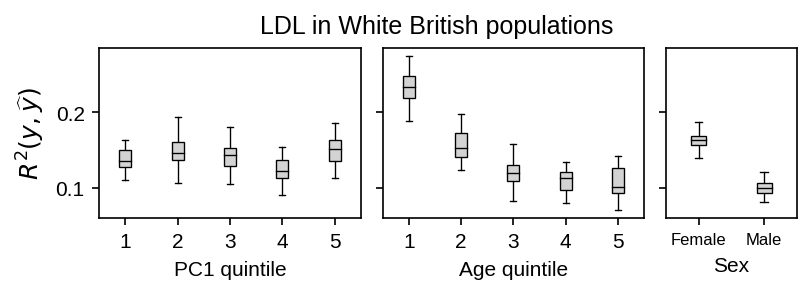

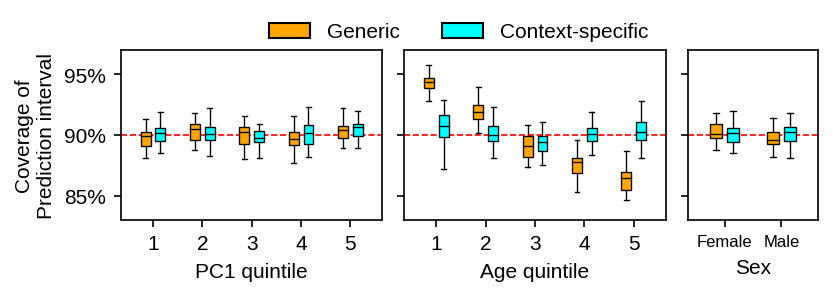

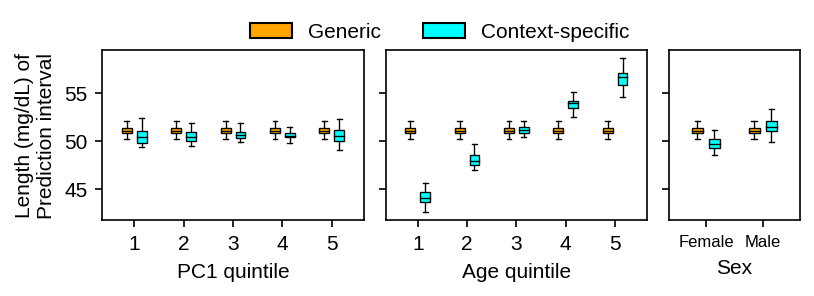

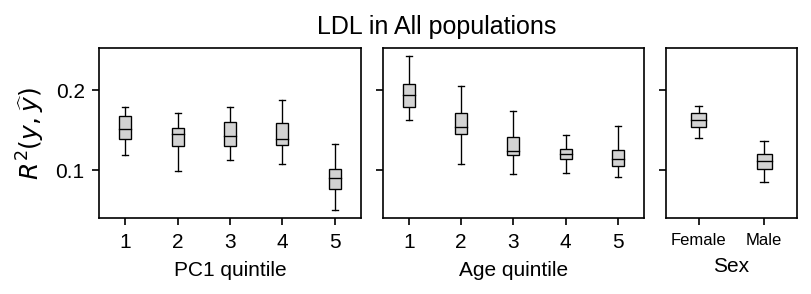

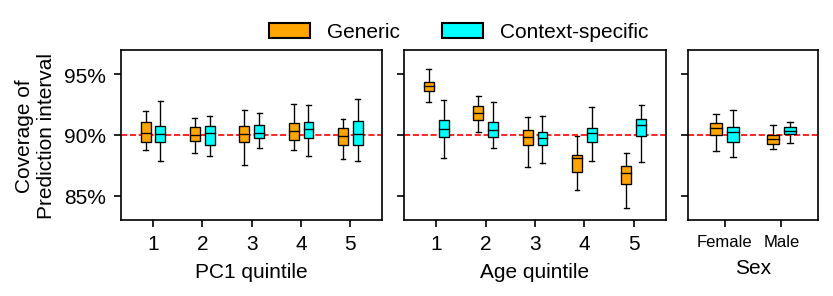

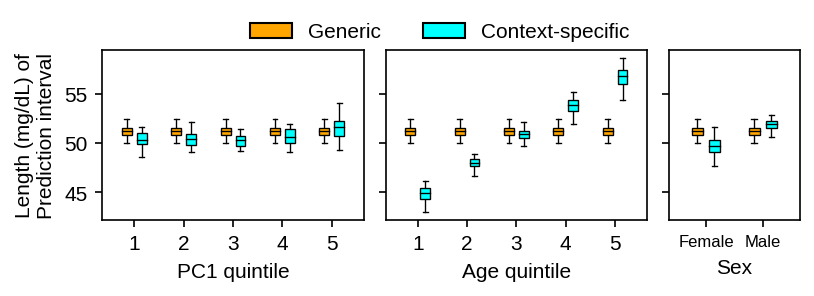

In [6]:
for trait in ["LDL"]:
    for group in ["white", "all"]:
        fig_r2, fig_coverage, fig_length = plot_wrapper(trait=trait, group=group)
        for fig, name in zip(
            [fig_r2, fig_coverage, fig_length], ["r2", "coverage", "length"]
        ):
            continue
            fig.savefig(f"results/{trait}-{group}.{name}.pdf", bbox_inches="tight")

In [6]:
assert False

AssertionError: 

# Legacy code

In [ ]:
def plot_main(trait, indiv_group):

    dict_label = {"LDL": "LDL", "height": "Height"}
    # read numerics
    df_predint_none = pd.read_csv(
        f"out/{EXPERIMENT_PREFIX}/summary/{trait}-{group}.mean.tsv",
        sep="\t",
    )
    df_predint_all = pd.read_csv(
        f"out/{EXPERIMENT_PREFIX}/summary/{trait}-{group}.mean+var.tsv",
        sep="\t",
    )

    dict_r2 = {
        group: df_predint_all[df_predint_all.group == group].pivot(
            index="seed", columns="subgroup", values="r2"
        )
        for group in df_predint_all.group.unique()
    }
    dict_cov1 = {
        group: df_predint_none[df_predint_none.group == group].pivot(
            index="seed", columns="subgroup", values="coverage"
        )
        for group in df_predint_none.group.unique()
    }
    dict_cov2 = {
        group: df_predint_all[df_predint_all.group == group].pivot(
            index="seed", columns="subgroup", values="coverage"
        )
        for group in df_predint_all.group.unique()
    }

    for g in dict_r2:
        cols = np.arange(1, len(dict_r2[g].columns) + 1).astype(str)
        dict_r2[g].columns = dict_cov1[g].columns = dict_cov2[g].columns = np.arange(
            1, len(dict_r2[g].columns) + 1
        ).astype(str)

    if trait == "height":
        ylim_r2 = [0.25, 0.8]
    elif trait == "LDL":
        ylim_r2 = [0, 0.3]
    else:
        raise NotImplementedError

    dict_r2 = {
        cov: pd.DataFrame({"mean": df.mean(), "sd": df.std()})
        for cov, df in dict_r2.items()
    }
    dict_cov1 = {
        cov: pd.DataFrame({"mean": df.mean(), "sd": df.std()})
        for cov, df in dict_cov1.items()
    }
    dict_cov2 = {
        cov: pd.DataFrame({"mean": df.mean(), "sd": df.std()})
        for cov, df in dict_cov2.items()
    }

    fig, axes = calpgs.plot_r2_cov(
        dict_r2=dict_r2,
        dict_cov1=dict_cov1,
        dict_cov2=dict_cov2,
        trait=dict_label[trait],
        xlabels=["PC1", "AGE", "SEX"],
        xlabel_map={
            "pred": "PGS",
            "PC1": "PC1 quintile",
            "AGE": "Age quintile",
            "SEX": "Sex",
        },
        ylim_cov=[0.83, 0.97],
        ylim_r2=ylim_r2,
        figsize=(3.8, 2.7),
    )
    fig.tight_layout()
    return fig, axes

In [ ]:
for trait in ["height", "LDL"]:
    for group in ["white", "all"]:
        fig, axes = plot_main(trait=trait, indiv_group=group)
#         fig.savefig(f"results/{trait}-{group}.pdf", bbox_inches="tight")